In [1]:
addprocs(4);

In [2]:
using POMDPs
using OPCSPs
using POMDPToolbox
using POMCP

In [3]:
N = 100
noises = 1.0:0.5:5.0
cheat_scores = Array(Float64, length(noises))
naive_scores = Array(Float64, length(noises))
feedback_scores = Array(Float64, length(noises))
mcts_scores = Array(Float64, length(noises))

for i in 1:length(noises)
    @show noise = noises[i]
    problems = Array(OPCSP, N)
    init_states = Array(OPCSPState, N)
    ds = Array(Array{Float64}, N)
    for j = 1:N
        p_rng = MersenneTwister(j)
        p = problems[j] = gen_problem(noise=noise,
                                  p=0.1,
                                  n_nodes=10,
                                  rng=p_rng)
        ib = initial_belief(p)
        init_states[j] = rand!(p_rng, create_state(p), ib)
        ds[j] = init_states[j].d
    end
    
    rsum = @parallel (+) for j in 1:N
        reward(problems[j], ds[j], cheat(problems[j], ds[j]))
    end
    cheat_scores[i] = rsum/N
    
    rsum = @parallel (+) for j in 1:N
        soln = solve_op(problems[j])
        reward(problems[j], ds[j], build_path(problems[j], soln))
    end
    naive_scores[i] = rsum/N
    
    rsum = @parallel (+) for j in 1:N
        path = solve_opcsp_feedback(problems[j], ds[j])
        reward(problems[j], ds[j], path)
    end
    feedback_scores[i] = rsum/N
    
    rsum = @parallel (+) for j in 1:N
        p = problems[j]
        solver = POMCPSolver(rollout_policy=SolveMeanFeedback(p),
                             c=sum(p.r),
                             tree_queries=50,
                             rng=MersenneTwister(j),
                             updater=OPCSPUpdater(p)
                            )
        policy = solve(solver, p)
        sim = HistoryRecorder(rng=MersenneTwister(1),
                              initial_state = init_states[j])
        u = updater(policy)
        ib = convert_belief(u, initial_belief(p))
        simulate(sim, p, policy, u, ib)
        path = Int[s.i for s in sim.state_hist]
        reward(p, ds[j], path)
    end
    mcts_scores[i] = rsum/N
end

noise = noises[i] = 1.0
noise = noises[i] = 1.5
noise = noises[i] = 2.0
noise = noises[i] = 2.5
noise = noises[i] = 3.0
noise = noises[i] = 3.5
noise = noises[i] = 4.0
noise = noises[i] = 4.5
noise = noises[i] = 5.0


In [4]:
using Gadfly

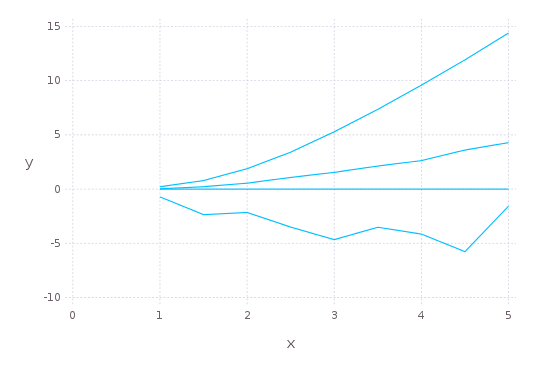

In [5]:
plot(layer(x=noises, y=cheat_scores.-naive_scores, Geom.line),
layer(x=noises, y=naive_scores.-naive_scores, Geom.line), 
layer(x=noises, y=feedback_scores.-naive_scores, Geom.line),
layer(x=noises, y=mcts_scores.-naive_scores, Geom.line))

In [6]:
naive_scores

9-element Array{Float64,1}:
 74.1131
 73.987 
 73.8608
 73.7347
 73.6085
 73.4823
 73.3562
 73.23  
 73.1039

In [7]:
mcts_scores

9-element Array{Float64,1}:
 73.3929
 71.6324
 71.7051
 70.2283
 68.9455
 69.9622
 69.2066
 67.4608
 71.529 

In [9]:
feedback_scores

9-element Array{Float64,1}:
 74.7079
 74.7184
 74.8521
 75.0344
 75.7876
 75.8317
 76.5672
 76.8624
 77.2793